<a href="https://colab.research.google.com/github/sr2echa/dirty-moni-detector/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wreckage011","key":"a54ab5182b2c40fd7a9a36c473a7368b"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                           title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/customer-shopping-trends-dataset            Customer Shopping Trends Dataset                   146KB  2023-10-05 06:45:37          15810        339  1.0              
nelgiriyewithana/billionaires-statistics-dataset              Billionaires Statistics Dataset (2023)             139KB  2023-09-29 13:39:28           8510        211  1.0              
jocelyndumlao/consumer-review-of-clothing-product             Consumer Review of Clothing Product                  4MB  2023-10-19 04:45:23            980         27  1.0              
victorahaji/worlds-air-quality-and-water-pollution-dataset    World's Air Q

In [ ]:
!kaggle datasets download -d vagifa/ethereum-frauddetection-dataset

  0% 0.00/923k [00:00<?, ?B/s]
100% 923k/923k [00:00<00:00, 197MB/s]


In [ ]:
!mkdir train

In [ ]:
!unzip ethereum-frauddetection-dataset.zip -d train

Archive:  ethereum-frauddetection-dataset.zip
  inflating: train/transaction_dataset.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

pd.set_option('display.max_columns', None)

In [ ]:
df=pd.read_csv('/content/train/transaction_dataset.csv')
df.head()

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,45.806785,6.589513,0.00,31.220000,1.200681,0.0,0.0,0.0,810,865.691093,586.466675,0.0,-279.224419,265.0,3.558854e+07,3.560317e+07,0.0,30.0,54.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,2.613269,0.385685,0.00,1.800000,0.032844,0.0,0.0,0.0,102,3.087297,3.085478,0.0,-0.001819,8.0,4.034283e+02,2.260809e+00,0.0,1.0,5.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,1.165453,0.358906,0.05,3.538616,1.794308,0.0,0.0,0.0,12,3.588616,3.589057,0.0,0.000441,8.0,5.215121e+02,0.000000e+00,0.0,0.0,7.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,500.000000,99.488840,0.00,450.000000,70.001834,0.0,0.0,0.0,34,1750.045862,895.399559,0.0,-854.646303,14.0,1.711105e+04,1.141223e+04,0.0,2.0,11.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,12.802411,2.671095,0.00,9.000000,0.022688,0.0,0.0,0.0,4619,104.318883,53.421897,0.0,-50.896986,42.0,1.628297e+05,1.235399e+05,0.0,4.0,23.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [ ]:
df['Time Diff between first and last (Mins)'].mean()

218333.25765166144

In [ ]:
cag = df.loc[df['FLAG'] > 0, 'Time Diff between first and last (Mins)'].values

In [ ]:
df.isna().sum()

Unnamed: 0                                                0
Index                                                     0
Address                                                   0
FLAG                                                      0
Avg min between sent tnx                                  0
Avg min between received tnx                              0
Time Diff between first and last (Mins)                   0
Sent tnx                                                  0
Received Tnx                                              0
Number of Created Contracts                               0
Unique Received From Addresses                            0
Unique Sent To Addresses                                  0
min value received                                        0
max value received                                        0
avg val received                                          0
min val sent                                              0
max val sent                            

0    7662
1    2179
Name: FLAG, dtype: int64


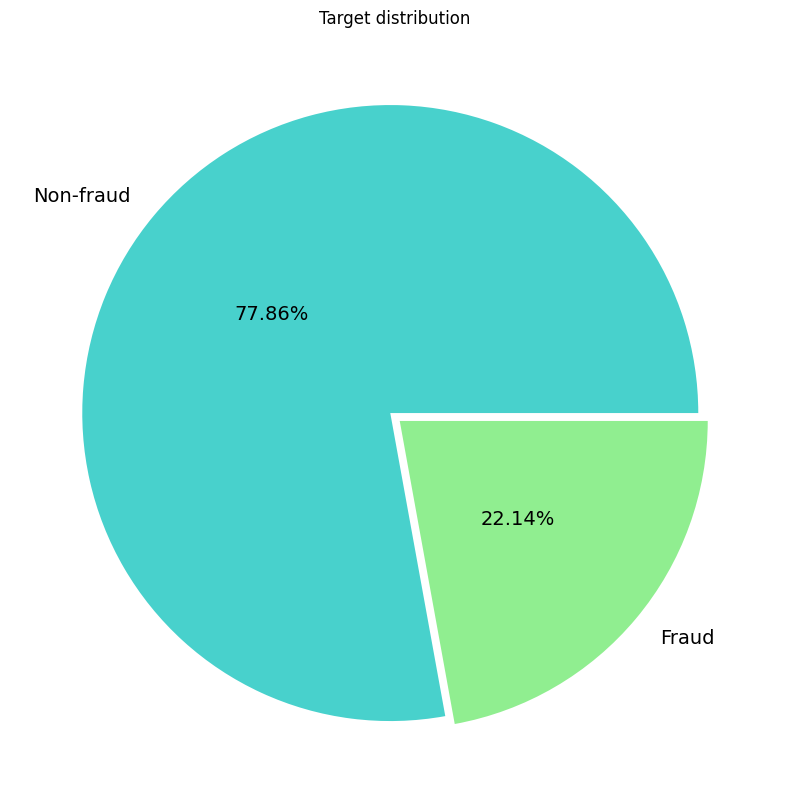

In [ ]:
print(df['FLAG'].value_counts())

pie, ax = plt.subplots(figsize=[15,10])
labels = ['Non-fraud', 'Fraud']
colors = ['mediumturquoise', 'lightgreen']
plt.pie(x = df['FLAG'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Target distribution')
plt.show()

<ipython-input-14-9145c739468c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


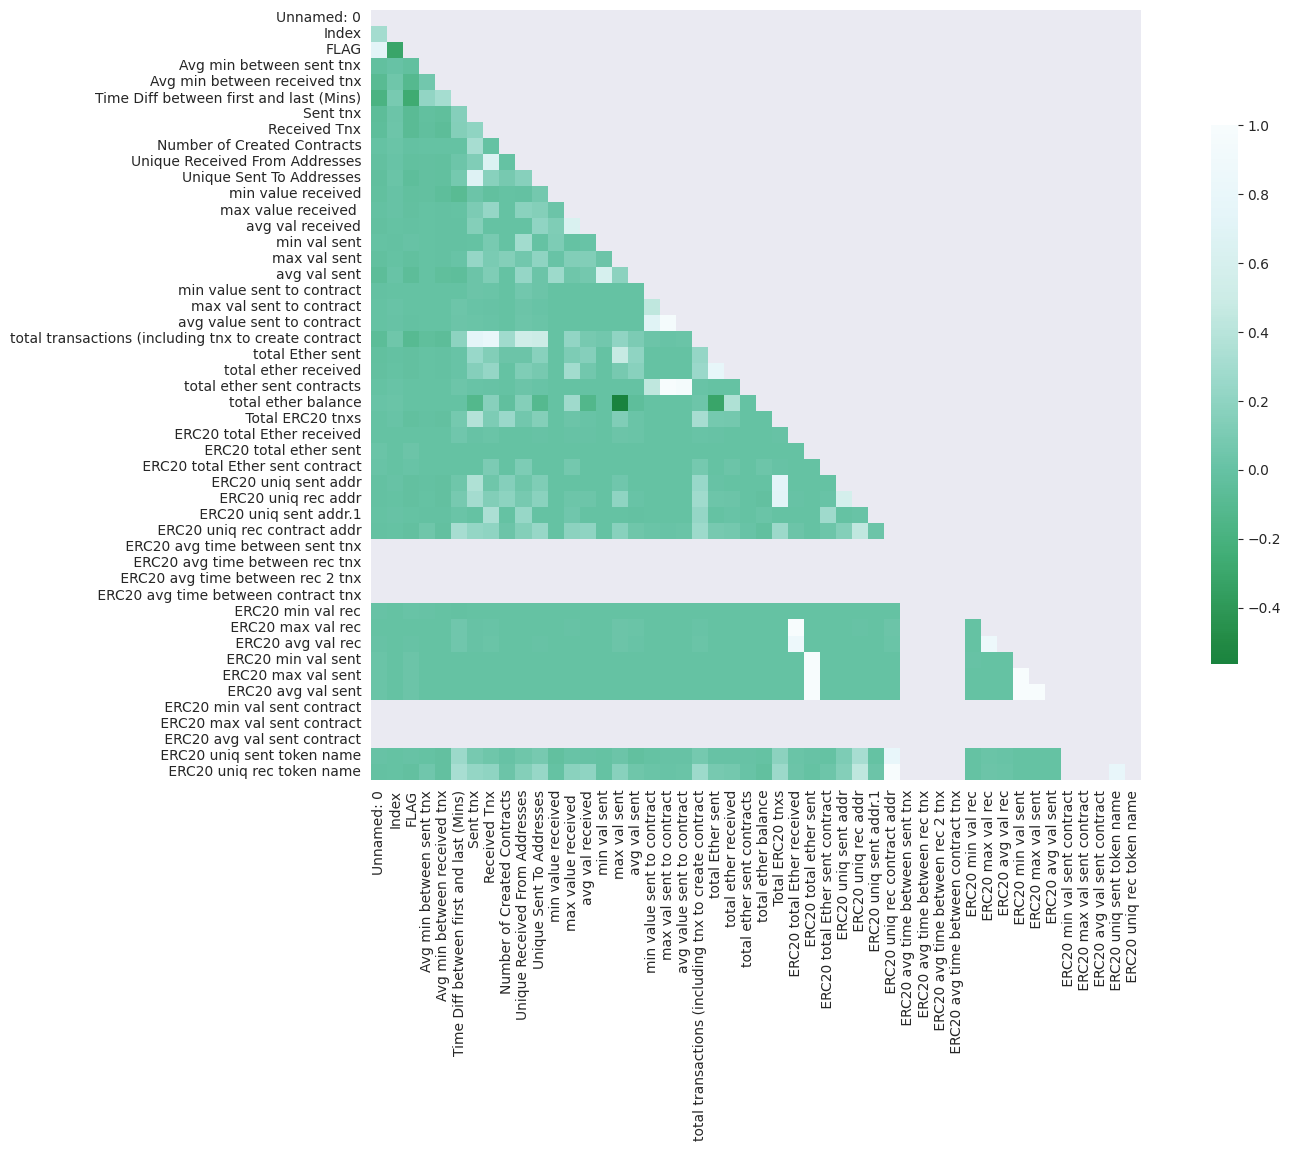

In [ ]:
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('dark'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='BuGn_r', center=0, square=True,cbar_kws={"shrink": .7})

In [ ]:
cat_col = [col for col in df.columns if df[col].dtype == 'object']
print('Categorical columns :',cat_col)
num_col = [col for col in df.columns if df[col].dtype != 'object']
print('Numerical columns :',num_col)

Categorical columns : ['Address', ' ERC20 most sent token type', ' ERC20_most_rec_token_type']
Numerical columns : ['Unnamed: 0', 'Index', 'FLAG', 'Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr', ' ERC20 avg time between sent tnx', ' ERC20 avg tim

In [ ]:
df.drop(df[cat_col], axis=1, inplace=True)

In [ ]:
df.fillna(df.median(), inplace=True)

In [ ]:
df.columns

Index(['Unnamed: 0', 'Index', 'FLAG', 'Avg min between sent tnx',
       'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'Unique Received From Addresses',
       'Unique Sent To Addresses', 'min value received', 'max value received ',
       'avg val received', 'min val sent', 'max val sent', 'avg val sent',
       'min value sent to contract', 'max val sent to contract',
       'avg value sent to contract',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether received',
       'total ether sent contracts', 'total ether balance',
       ' Total ERC20 tnxs', ' ERC20 total Ether received',
       ' ERC20 total ether sent', ' ERC20 total Ether sent contract',
       ' ERC20 uniq sent addr', ' ERC20 uniq rec addr',
       ' ERC20 uniq sent addr.1', ' ERC20 uniq rec contract addr',
       ' ERC20 avg time between sent tnx', ' ERC20 avg time be

In [ ]:
col = ['FLAG','Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether sent contracts', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq rec contract addr', ' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx', ' ERC20 min val rec', ' ERC20 max val rec', ' ERC20 avg val rec', ' ERC20 min val sent', ' ERC20 max val sent', ' ERC20 avg val sent', ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract']

df = df[col]


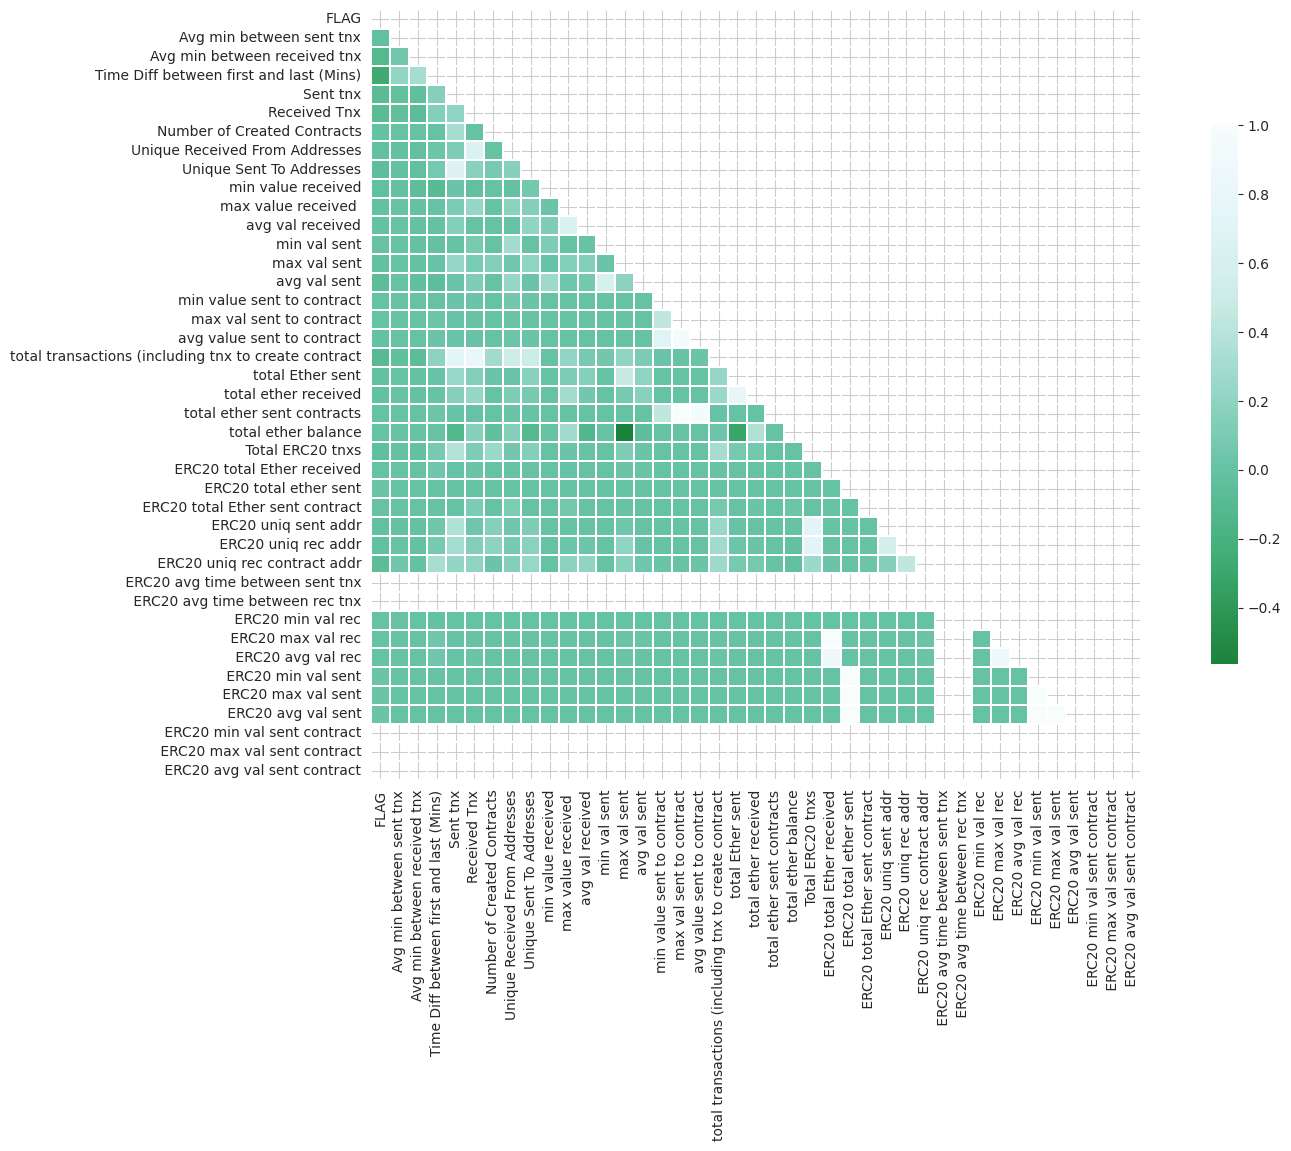

In [ ]:
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='BuGn_r', center=0, linewidths=0.1, square=True,cbar_kws={"shrink": .7})

In [ ]:
df.columns

Index(['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'Unique Received From Addresses',
       'Unique Sent To Addresses', 'min value received', 'max value received ',
       'avg val received', 'min val sent', 'max val sent', 'avg val sent',
       'min value sent to contract', 'max val sent to contract',
       'avg value sent to contract',
       'total transactions (including tnx to create contract',
       'total Ether sent', 'total ether received',
       'total ether sent contracts', 'total ether balance',
       ' Total ERC20 tnxs', ' ERC20 total Ether received',
       ' ERC20 total ether sent', ' ERC20 total Ether sent contract',
       ' ERC20 uniq sent addr', ' ERC20 uniq rec addr',
       ' ERC20 uniq rec contract addr', ' ERC20 avg time between sent tnx',
       ' ERC20 avg time between rec tnx', ' ERC20 min val rec',
       ' ERC20 max 

In [ ]:
df.shape

(9841, 41)

In [ ]:
# Split the data into features (X) and the target variable (y)
X = df.drop('FLAG', axis=1)
y = df['FLAG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
clf = XGBClassifier()
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [100, 200],
    'subsample': [0.3, 0.5, 0.9],
    'max_depth': [2, 3, 4],
    'colsample_bytree': [0.3, 0.5, 0.7]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

Fitting 3 folds for each of 162 candidates, totalling 486 fits


In [ ]:
y_pred = best_estimator.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)


Accuracy: 0.99
Precision: 0.97
Confusion Matrix:
[[1531   11]
 [  14  413]]


In [ ]:
import joblib
model_filename = "dmd.pkl"
joblib.dump(grid_search, model_filename)

['dmd.pkl']